In [1]:
using JuMP, Cbc, Clp, Random, Statistics, Plots

In [15]:
N = collect(50:50:1000)
K = collect(100:100:1000)
M = 10

10

Confidence Interval for Ni=50: [-1354.826073020216,-1292.8939269797843]
Confidence Interval for Ni=100: [-1344.3493938420218,-1304.4106061579785]
Confidence Interval for Ni=150: [-1323.0838774610515,-1283.5961225389478]
Confidence Interval for Ni=200: [-1355.5318001105222,-1317.1281998894776]
Confidence Interval for Ni=250: [-1326.114970810397,-1290.2450291896032]
Confidence Interval for Ni=300: [-1338.4856116680055,-1299.7277216653272]
Confidence Interval for Ni=350: [-1320.36659456724,-1294.4505482899062]
Confidence Interval for Ni=400: [-1331.616057111841,-1297.6939428881603]
Confidence Interval for Ni=450: [-1331.6910930409656,-1308.5355736257018]
Confidence Interval for Ni=500: [-1326.0996260118304,-1301.9483739881698]
Confidence Interval for Ni=550: [-1320.444175637393,-1288.9958243626047]
Confidence Interval for Ni=600: [-1318.7942985415411,-1306.7057014584611]
Confidence Interval for Ni=650: [-1325.1022768007679,-1303.5654155069146]
Confidence Interval for Ni=700: [-1321.469359

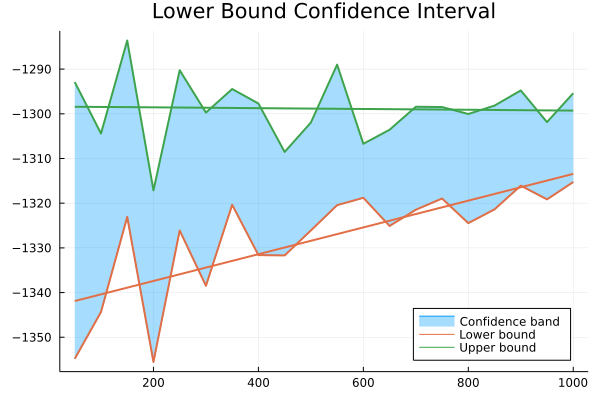

In [16]:
LB_left_Dict = Dict{Int, Float64}();
LB_right_Dict = Dict{Int, Float64}();
x_Dict =  Dict{Int, Vector{Float64}}();
for Ni in N    
    obj_value_list = []
    x_list = []
    for i=1:M    
        ξ = rand(50:150,Ni)
        master = Model(Clp.Optimizer)
        set_optimizer_attribute(master, "LogLevel",0)
        @variables(master,begin
            x ≥ 0
            y[1:Ni] ≥ 0
            w[1:Ni] ≥ 0
        end)
        @constraints(master,begin
            ct1[s=1:Ni], y[s] ≤ ξ[s]
            ct2[s=1:Ni], y[s] + w[s] ≤ x
        end)
        @objective(master, Min, 10*x + (1/Ni)*sum(-25*y[s] - 5*w[s] for s in 1:Ni))
        optimize!(master)
        append!(x_list,value(x))
        append!(obj_value_list, objective_value(master))
    end

    V̄=sum(obj_value_list)/M
    LB_left = V̄ - 1.96*std(obj_value_list)/sqrt(M)
    LB_right = V̄ + 1.96*std(obj_value_list)/sqrt(M)
    push!(LB_left_Dict,Ni =>LB_left)
    push!(LB_right_Dict,Ni =>LB_right)
    push!(x_Dict, Ni => x_list)
    println("Confidence Interval for Ni=$(Ni): [$(LB_left),$(LB_right)]")
end
# println(sort(x_Dict))
# println(LB_left_Dict)
# println(LB_right_Dict)

u = x-> LB_right_Dict[x]
plot(x=N,LB_left_Dict, fillrange=u,fillalpha = 0.35,label = "Confidence band", legend = :bottomright, title = "Lower Bound Confidence Interval")
plot!(x=N,LB_left_Dict, smooth=true, label = "Lower bound",lw = 2)
plot!(x=N,LB_right_Dict, smooth=true, label = "Upper bound",lw = 2)

In [17]:
obj_value_list = []
UB_right_Dict = Dict{Float64, Float64}();
for x̂ in x_Dict[1000]
    Ki=1000
    for i=1:M    
        ξ = rand(50:150,Ki)
        UB_model = Model(Clp.Optimizer)
        set_optimizer_attribute(UB_model, "LogLevel",0)
        @variables(UB_model,begin
            y[1:Ki] ≥ 0
            w[1:Ki] ≥ 0
        end)
        @constraints(UB_model,begin
            ct1[s=1:Ki], y[s] ≤ ξ[s]
            ct2[s=1:Ki], y[s] + w[s] ≤ x̂
        end)
        @objective(UB_model, Min, 10*x̂ + (1/Ki)*sum(-25*y[s] - 5*w[s] for s in 1:Ki))
        optimize!(UB_model)
        append!(obj_value_list, objective_value(UB_model))
    end
    V̄=sum(obj_value_list)/M
    UB_right = V̄ + 1.96*std(obj_value_list)/sqrt(M)
    push!(UB_right_Dict,x̂ =>UB_right)
end

x_chosen = reduce((x, y) -> UB_right_Dict[x] ≤ UB_right_Dict[y] ? x : y, keys(UB_right_Dict)) # x̄ que gera a menor entre as M cotas superiores

println(x_chosen)
println(UB_right_Dict)

126.000000000001
Dict(126.00000000000995 => -11801.367687062255, 126.000000000001 => -13117.10404040488, 123.0 => -3919.79154901902, 125.00000000000696 => -1298.5982459587476, 122.00000000000497 => -9167.978627386423, 123.00000000000796 => -2611.4650853773337, 125.00000000000497 => -10487.631689170104, 126.00000000000696 => -6541.281661553, 123.00000000000298 => -7853.943653419552, 125.00000000000398 => -5234.124813543686)


Confidence Interval for Ki=100: [-14414.468403350724,-14384.655596649316]
Confidence Interval for Ki=200: [-15726.15659325083,-15693.107406749203]
Confidence Interval for Ki=300: [-17050.285079659654,-17016.805587007046]
Confidence Interval for Ki=400: [-18358.979216495827,-18325.71145017085]
Confidence Interval for Ki=500: [-19657.0524481193,-19623.94221854738]
Confidence Interval for Ki=600: [-20962.59870302197,-20929.71596364469]
Confidence Interval for Ki=700: [-22274.089024701283,-22241.877070536804]
Confidence Interval for Ki=800: [-23589.086200621605,-23557.399894616457]
Confidence Interval for Ki=900: [-24903.931505956123,-24872.510144837495]
Confidence Interval for Ki=1000: [-26214.840777287198,-26184.096873506427]


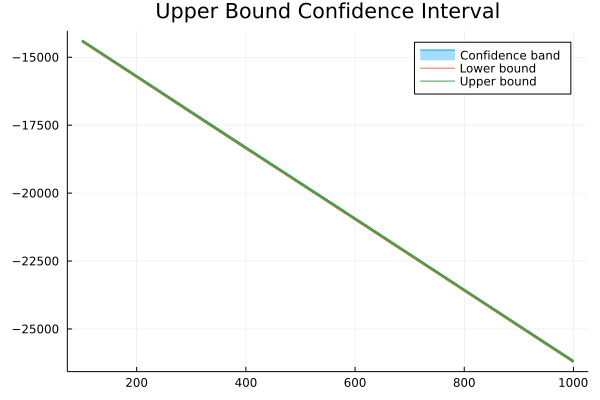

In [18]:
UB_left_Dict = Dict{Float64, Float64}();
UB_right_Dict = Dict{Float64, Float64}();

for Ki in K
    for i=1:M    
        ξ = rand(50:150,Ki)
        UB_model = Model(Clp.Optimizer)
        set_optimizer_attribute(UB_model, "LogLevel",0)
        @variables(UB_model,begin
            y[1:Ki] ≥ 0
            w[1:Ki] ≥ 0
        end)
        @constraints(UB_model,begin
            ct1[s=1:Ki], y[s] ≤ ξ[s]
            ct2[s=1:Ki], y[s] + w[s] ≤ x_chosen
        end)
        @objective(UB_model, Min, 10*x_chosen + (1/Ki)*sum(-25*y[s] - 5*w[s] for s in 1:Ki))
        optimize!(UB_model)
        append!(obj_value_list, objective_value(UB_model))
    end
    V̄=sum(obj_value_list)/M
    UB_left = V̄ - 1.96*std(obj_value_list)/sqrt(M)
    UB_right = V̄ + 1.96*std(obj_value_list)/sqrt(M)
    push!(UB_left_Dict,Ki =>UB_left)
    push!(UB_right_Dict,Ki =>UB_right)
    println("Confidence Interval for Ki=$(Ki): [$(UB_left),$(UB_right)]")

end

u = x-> UB_right_Dict[x]
plot(x=N,UB_left_Dict, fillrange=u,fillalpha = 0.35,label = "Confidence band", legend = :topright, title = "Upper Bound Confidence Interval")
plot!(x=N,UB_left_Dict, smooth=true, label = "Lower bound",lw = 2)
plot!(x=N,UB_right_Dict, smooth=true, label = "Upper bound",lw = 2)

In [20]:
#Plotando o lower bound mais conservador e o Upper Bound mais conservador
# u = x-> UB_right_Dict[x]
# plot(x=N,LB_left_Dict, fillrange=u,fillalpha = 0.35,label = "Confidence band", legend = :topright, title = "SAA Confidence Interval")
# plot!(x=N,LB_left_Dict, smooth=true, label = "Lower bound",lw = 2)
# plot!(x=N,UB_right_Dict, smooth=true, label = "Upper bound",lw = 2)